In [2]:
import os
import pandas as pd

import sys
from datetime import datetime
sys.path.append('../../Scripts')

표준테이블 목록
|순번|테이블명|설명|획득방법|
|:-:|:-:|:-:|:-:|
|1|교차로번호      |각 교차로의 이름, 위치|DB|
|2|방위각정보      |각 교차로의 (현시, 링)별 진입·진출 방위각|DB|
|3|이동류번호      |각 교차로의 (현시, 링)별 이동류번호|DB|
|4|신호계획        |각 교차로의 신호계획|DB|
|5|신호이력        |각 교차로의 (현시, 링)별 현시시간|DB|
|6|교차로-노드 매칭 |교차로번호와 노드ID를 매칭정보 및 parent/child 여부|수작업|
|7|유턴교차로정보   |각 유턴교차로별 부모교차로, 방향, 유턴옵션|수작업|
|8|연동교차로정보   |각 연동교차로별 부모교차로, (현시, 링)별 진입진출ID|수작업|
|9|NEMA 정보       |NEMA에서 정의한 이동류번호에 대한 진입·진출 방향|수작업|
|10|<미정>         |(현시, 링)별로 이동류번호가 두 개 이상 부여된 경우에 대비한 테이블|수작업|

스크립트 목록
|스크립트명|`preprocess_daily.py`|`generate_signal.py`|
|:-:|:-:|:-:|
|실행주기|매일|매5분|
|목적|신호생성에 사용되는 중간산출물 생성|실시간 신호파일 생성|
|산출물목록|`match.csv`<br>`match6.csv`<br>`matching.csv`<br>`node2num_cycles.json`|`sn_[timestamp].add.xml`|

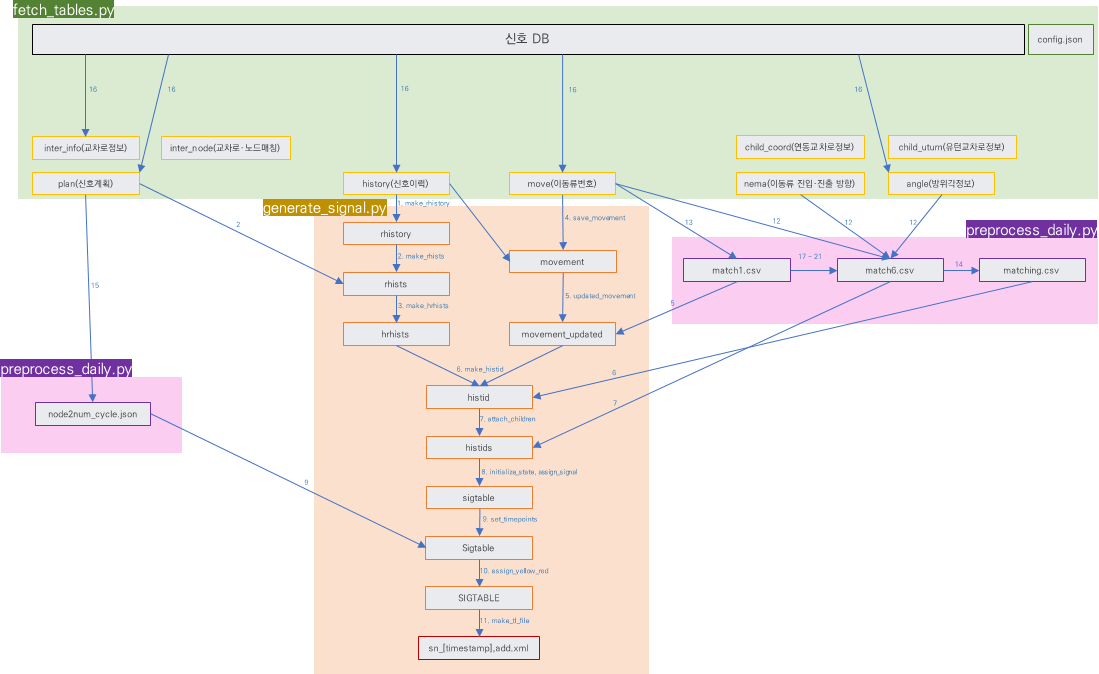

## `preprocess_daily.py`

In [3]:
# 매일 실행하는 스크립트
from preprocess_daily import DailyPreprocessor
dp = DailyPreprocessor()

# 1. 데이터 불러오기
dp.load_data()
# 2. 중간산출물 만들기
dp.get_intermediates()
# 3. 이슈사항 저장
dp.write_issues()

1. 데이터를 로드합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
1-3. 네트워크의 모든 clean state requirement들을 체크했습니다.
1-4. 테이블들의 무결성 검사를 완료했습니다.
2. 중간산출물을 생성합니다.


이동류정보 불러오는 중: 100%|██████████| 17280/17280 [00:46<00:00, 368.16it/s]


2-1. 매칭 테이블들을 생성했습니다.
2-2. node2num_cycles.json를 저장했습니다.
3. 이슈사항을 저장합니다.


In [4]:
# 2-1-1 match1 : 각 교차로마다 (A현시번호, B현시번호)를 (A이동류번호, B이동류번호)로 대응시키는 테이블입니다.
# 이러한 대응은 유일하지 않을 수 있지만(시차제), 임의의 대응 하나만 만들어놓아도 전체 프로세스에는 문제 없습니다.
dp.match1[:15]
# 이때, [표준테이블 3 : 이동류정보]를 사용합니다.
# [이동류정보] 테이블은 매 1초마다 바뀌는 테이블로서, 스크립트는 5초마다 한번씩 이 테이블을 불러옵니다.
# path_move = os.path.join(dp.path_tables, 'move')
# move = pd.read_csv(os.path.join(path_move, os.listdir(path_move)[400]), index_col=0)
# move

inter_no  phas_A  phas_B  move_A  move_B
0        175       1       1       8       4
1        175       2       2       7       3
2        175       3       3       6       1
3        175       3       4       6       2
4        175       4       4       5       2
5        176       1       1       8       4
6        176       2       2       8       3
7        176       3       3       5      18
8        177       1       1       8       4
9        177       2       2       7       3
10       177       3       3      17      18
11       177       4       4       5       1
12       178       1       1       8       4
13       178       2       2       7       3
14       178       3       3       5       2

In [5]:
# 2-1-2 match2 : match1을 계층화합니다. (세로로 길게 늘립니다.)
dp.match2[:15]

inter_no  phase_no ring_type  move_no
0       175         1         A        8
0       175         1         B        4
1       175         2         A        7
1       175         2         B        3
2       175         3         A        6
2       175         3         B        1
4       175         4         A        5
3       175         4         B        2
5       176         1         A        8
5       176         1         B        4
6       176         2         A        8
6       176         2         B        3
7       176         3         A        5
7       176         3         B       18
8       177         1         A        8

In [6]:
# 2-1-3 match3 : 각 행에 진입방향, 진출방향을 부여합니다.
dp.match3[:15]
# 이때 [표준테이블 9 : NEMA 정보]를 사용합니다.
# [NEMA 정보] 테이블은 한 번 만들어두고 계속 사용하는 테이블입니다.
# dp.nema

inter_no  phase_no ring_type  move_no inc_dir out_dir
0        175         1         A        8       남       북
1        175         1         B        4       북       남
2        175         2         A        7       북       동
3        175         2         B        3       남       서
4        175         3         A        6       동       서
5        175         3         B        1       동       남
6        175         4         A        5       서       북
7        175         4         B        2       서       동
8        176         1         A        8       남       북
9        176         1         B        4       북       남
10       176         2         A        8       남       북
11       176         2         B        3       남       서
12       176         3         A        5       서       북
13       176         3         B       18     NaN     NaN
14       177         1         A        8       남       북

In [7]:
# 2-1-4 match4 : 각 행에 진입각도, 진출각도를 부여합니다.
dp.match4[:15]
# 이때 [표준테이블 2 : 방위각정보]를 사용합니다.
# [방위각정보] 테이블은 하루에 한 번씩 업데이트되는 테이블입니다.
# dp.angle

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle
0        175         1         A        8       남       북       179       004
1        175         1         B        4       북       남       003       176
2        175         2         A        7       북       동       001       095
3        175         2         B        3       남       서       179       270
4        175         3         A        6       동       서       090       270
5        175         3         B        1       동       남       090       180
6        175         4         A        5       서       북       268       000
7        175         4         B        2       서       동       270       090
8        176         1         A        8       남       북       180       000
9        176         1         B        4       북       남       359       180
10       176         2         A        8       남       북       180       000
11       176         2         B        3       남       서       180       270
12       176         3         A        5       서       북       270       356
13       176         3         B       18     NaN     NaN       NaN       NaN
14       177         1         A        8       남       북       180       000

In [8]:
# 2-1-5 match5 : 각 행에 진입엣지id, 진출엣지id를 부여합니다.
# 이때 네트워크 파일을 사용하며, shape와 코사인유사도(내적)을 사용하는 과정이 있습니다.
dp.match5[:20]

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0        175         1         A        8       남       북       179       004   
1        175         1         B        4       북       남       003       176   
2        175         2         A        7       북       동       001       095   
3        175         2         B        3       남       서       179       270   
4        175         3         A        6       동       서       090       270   
5        175         3         B        1       동       남       090       180   
6        175         4         A        5       서       북       268       000   
7        175         4         B        2       서       동       270       090   
8        176         1         A        8       남       북       180       000   
9        176         1         B        4       북       남       359       180   
10       176         2         A        8       남       북       180       000   
11       176         2         B        3       남       서       180       270   
12       176         3         A        5       서       북       270       356   
13       176         3         B       18     NaN     NaN       NaN       NaN   
14       177         1         A        8       남       북       180       000   
15       177         1         B        4       북       남       001       176   
16       177         2         A        7       북       동       000       090   
17       177         2         B        3       남       서       179       270   
18       177         3         A       17     NaN     NaN       NaN       NaN   
19       177         3         B       18     NaN     NaN       NaN       NaN   

           inc_edge          out_edge node_id  
0     -571542797_02      571500487_01      i0  
1     -571500487_01      571542797_02      i0  
2     -571500487_01      571545870_01      i0  
3     -571542797_02      571510153_01      i0  
4      571545870_02      571510153_01      i0  
5      571545870_02      571542797_02      i0  
6      571510153_02      571500487_01      i0  
7      571510153_02      571545870_01      i0  
8     -571542810_01  -571542797_02.99      i1  
9   571542797_02.99      571542810_01      i1  
10    -571542810_01  -571542797_02.99      i1  
11    -571542810_01      571543469_01      i1  
12     571543469_02  -571542797_02.99      i1  
13              NaN               NaN      i1  
14    -571542809_01      571542811_01      i2  
15     571542811_02      571542809_01      i2  
16     571542811_02      571542107_01      i2  
17    -571542809_01      571542809_01      i2  
18              NaN               NaN      i2  
19              NaN               NaN      i2

In [13]:
# 2-1-6 match6 : 부교차로(유턴교차로와 연동교차로)에도 진입엣지id, 진출엣지id를 부여합니다.
# 부교차로의 다른 컬럼들 (inter_no ~ out_angle)은 주교차로의 값을 그대로 따릅니다.
# 부교차로의 진입엣지id, 진출엣지id는 별도로 부여되지 않으면 NaN이 됩니다.
# 마지막으로 노드id(네트워크에서의 junction id)도 부여됩니다.
dp.match6[:60]

# 이때 [표준테이블 6 : 교차로-노드 매칭]과 [표준테이블 7 : 유턴교차로정보], [표준테이블 8 : 연동교차로정보]가 사용됩니다.
# dp.inter_node
# dp.uturn
# dp.load_tables()
# dp.coord

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0        175         1         A        8       남       북       179       004   
1        175         1         B        4       북       남       003       176   
2        175         2         A        7       북       동       001       095   
3        175         2         B        3       남       서       179       270   
4        175         3         A        6       동       서       090       270   
5        175         3         B        1       동       남       090       180   
6        175         4         A        5       서       북       268       000   
7        175         4         B        2       서       동       270       090   
0        175         1         A        8       남       북       179       004   
1        175         1         B        4       북       남       003       176   
2        175         2         A       19       북       동       001       095   
3        175         2         B        3       남       서       179       270   
4        175         3         A        6       동       서       090       270   
5        175         3         B        1       동       남       090       180   
6        175         4         A        5       서       북       268       000   
7        175         4         B        2       서       동       270       090   
8        176         1         A        8       남       북       180       000   
9        176         1         B        4       북       남       359       180   
10       176         2         A        8       남       북       180       000   
11       176         2         B        3       남       서       180       270   
12       176         3         A        5       서       북       270       356   
13       176         3         B       18     NaN     NaN       NaN       NaN   
14       177         1         A        8       남       북       180       000   
15       177         1         B        4       북       남       001       176   
16       177         2         A        7       북       동       000       090   
17       177         2         B        3       남       서       179       270   
18       177         3         A       17     NaN     NaN       NaN       NaN   
19       177         3         B       18     NaN     NaN       NaN       NaN   
20       177         4         A        5       서       북       268       000   
21       177         4         B        1       동       남       090       180   
0        177         1         A        8       남       북       180       000   
1        177         1         B        4       북       남       001       176   
2        177         2         A        7       북       동       000       090   
3        177         2         B        3       남       서       179       270   
4        177         3         A       17     NaN     NaN       NaN       NaN   
5        177         3         B       18     NaN     NaN       NaN       NaN   
6        177         4         A        5       서       북       268       000   
7        177         4         B        1       동       남       090       180   
0        178         1         A       20     NaN     NaN       NaN       NaN   
1        178         1         B       20     NaN     NaN       NaN       NaN   
2        178         2         A       20     NaN     NaN       NaN       NaN   
3        178         2         B       20     NaN     NaN       NaN       NaN   
4        178         3         A       20     NaN     NaN       NaN       NaN   
5        178         3         B       20     NaN     NaN       NaN       NaN   
6        178         4         A       20     NaN     NaN       NaN       NaN   
7        178         4         B       20     NaN     NaN       NaN       NaN   
22       178         1         A        8       남       북       180       000   
23       178         1         B        4       북       남       000       180   
24       178         2         A   

In [12]:
# 2-1-7 matching : 부교차로(유턴교차로와 연동교차로)에도 진입엣지id, 진출엣지id를 부여합니다.
# 또한, 모든 교차로에 대하여, 가능한 모든 이동류번호에 대하여 진입엣지id, 진출엣지id를 부여합니다.
dp.matching[:60]

inter_no  move_no inc_dir out_dir         inc_edge          out_edge  \
0        175        1       동       남     571545870_02      571542797_02   
1        175        2       서       동     571510153_02      571545870_01   
2        175        3       남       서    -571542797_02      571510153_01   
3        175        4       북       남    -571500487_01      571542797_02   
4        175        5       서       북     571510153_02      571500487_01   
5        175        6       동       서     571545870_02      571510153_01   
6        175        7       북       동    -571500487_01      571545870_01   
7        175        8       남       북    -571542797_02      571500487_01   
8        175       21       북       서    -571500487_01      571510153_01   
9        175       21       서       남     571510153_02      571542797_02   
10       175       21       남       동    -571542797_02      571545870_01   
11       175       21       동       북     571545870_02      571500487_01   
12       175       19       북       동     571500487_02   571500487_01.32   
13       176        3       남       서    -571542810_01      571543469_01   
14       176        4       북       남  571542797_02.99      571542810_01   
15       176        5       서       북     571543469_02  -571542797_02.99   
16       176        8       남       북    -571542810_01  -571542797_02.99   
17       176       21       북       서  571542797_02.99      571543469_01   
18       176       21       서       남     571543469_02      571542810_01   
19       177        1       동       남     571542107_02      571542809_01   
20       177        2       서       동    -571542809_01      571542107_01   
21       177        3       남       서    -571542809_01      571542809_01   
22       177        4       북       남     571542811_02      571542809_01   
23       177        5       서       북    -571542809_01      571542811_01   
24       177        6       동       서     571542107_02      571542809_01   
25       177        7       북       동     571542811_02      571542107_01   
26       177        8       남       북    -571542809_01      571542811_01   
27       177       21       북       서     571542811_02      571542809_01   
28       177       21       서       남    -571542809_01      571542809_01   
29       177       21       남       동    -571542809_01      571542107_01   
30       177       21       동       북     571542107_02      571542811_01   
31       178        1       동       남    -571500475_01      571540304_01   
32       178        2       서       동  571540303_02.21      571500475_01   
33       178        3       남       서     571540304_02      571540303_01   
34       178        4       북       남     571556450_02      571540304_01   
35       178        5       서       북  571540303_02.21      571556450_01   
36       178        6       동       서    -571500475_01      571540303_01   
37       178        7       북       동     571556450_02      571500475_01   
38       178        8       남       북     571540304_02      571556450_01   
39       178       21       북       서     571556450_02      571540303_01   
40       178       21       서       남  571540303_02.21      571540304_01   
41       178       21       남       동     571540304_02      571500475_01   
42       178       21       동       북    -571500475_01      571556450_01   
43       178       19       동       서     571556452_01      571556452_02   
44       178       19       남       북     571500475_02   571500475_01.26   
45       178       19       북       남     571540303_02     -571540303_02   
46       201        1       동       남     571500617_02      571500569_01   
47       201        2       서       동     571500618_02      571500617_01   
48       201        3       남       서    -571500569_01      571500618_01   
49       201        4       북       남     571500583_01      571500569_01   
50       201        5       서       북     571500618_02      571500583_02   
51       201        6       동       서     571500617_

## `generate_signal.py`

In [10]:
# 5분마다 실행하는 스크립트
from generate_signals import SignalGenerator
sg = SignalGenerator()

# 1. 데이터 준비
sg.prepare_data()
# 2. 신호이력 전처리
sg.process_history()
# 3. 이동류정보 전처리
sg.process_movement()
# 4. 통합테이블 생성
sg.make_histids()
# 5. 신호 생성
sg.get_signals()
# 6. 이슈사항 저장
sg.write_issues()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.
3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.
5. 신호를 생성합니다.
6. 이슈사항을 저장합니다.


In [23]:
### 2. 신호이력 전처리

# 2-1. rhistory : 현재시점 기준으로 최근 30분간의 신호이력을 불러옵니다.
# 종료유닉스였던 것을 시작유닉스로 바꿉니다.
# 나중을 위해 현재시각 + 10분의 시점에 한주기의 신호를 추가합니다.
# rhistory에 모든 교차로번호가 존재하지 않으면 해당 교차로번호에 대한 신호이력을 추가합니다. (at 최근 프로그램 시작시각)
sg.rhistory[:15]
# 이때 [표준테이블 5 : 신호이력]을 사용합니다.
# [신호이력] 테이블은 매 주기마다 업데이트되는 테이블입니다.
# sg.history

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1909       176  1704416540       37      103       40        0        0   
1910       175  1704416540       43       45       55       37        0   
1911       202  1704416570       46      114        0        0        0   
1912       201  1704416560       33       36       25       58       18   
1913       206  1704416610       45       53       26       26        0   
1914       210  1704416600       43       43       70       24        0   
1915       178  1704416690       38       39       43       50        0   
1916       177  1704416700       43       27       70       40        0   
1917       202  1704416729       46      114        0        0        0   
1918       176  1704416719       37      103       40        0        0   
1919       175  1704416720       43       45       55       37        0   
1920       201  1704416730       33       36       25       58       18   
1921       206  1704416760       45       53       26       26        0   
1922       210  1704416780       43       43       70       24        0   
1923       178  1704416860       38       39       43       50        0   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1909        0        0        0       37      103       40        0        0   
1910        0        0        0       43       45       33       59        0   
1911        0        0        0       46      114        0        0        0   
1912        0        0        0       33       36       25       58       18   
1913        0        0        0       45       53       26       26        0   
1914        0        0        0       28       58       70       24        0   
1915        0        0        0       38       39       71       22        0   
1916        0        0        0       43       27       70       40        0   
1917        0        0        0       46      114        0        0        0   
1918        0        0        0       37      103       40        0        0   
1919        0        0        0       43       45       33       59        0   
1920        0        0        0       33       36       25       58       18   
1921        0        0        0       45       53       26       26        0   
1922        0        0        0       28       58       70       24        0   
1923        0        0        0       38       39       71       22        0   

      dura_B6  dura_B7  dura_B8  cycle  
1909        0        0        0    180  
1910        0        0        0    180  
1911        0        0        0    160  
1912        0        0        0    170  
1913        0        0        0    150  
1914        0        0        0    180  
1915        0        0        0    170  
1916        0        0        0    180  
1917        0        0        0    160  
1918        0        0        0    180  
1919        0        0        0    180  
1920        0        0        0    170  
1921        0        0        0    150  
1922        0        0        0    180  
1923        0        0        0    170

In [21]:
# 2-2. rhists : 참값판단프로세스
# rhistory에서 각 행마다 시간차이와 현시합을 비교하여 그 차이가 5초 이내이면 참값으로 판단하고, 그렇지 않으면 거짓값으로 판단합니다.
# 만약 해당 행이 거짓값이면, 다음 과정을 진행합니다.
# 이전 행과의 차이가 주기의 두 배보다 크면 신호계획에서 현시값을 불러와 채워나갑니다. (그 차이가 주기보다 작거나 같아질때까지) <결측치 처리>
# 이전 행과의 차이가 주기의 두 배보다 크지 않으면 해당 행을 "삭제"하거나 일정한 비율로 "대체"합니다. <이상치 처리>
sg.rhists[:15]

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
6        176  1704417620       37      103       40        0        0   
7        176  1704417800       37      103       40        0        0   
8        176  1704417980       37      103       40        0        0   
9        176  1704418160       37      103       40        0        0   
10       176  1704418520       37      103       40        0        0   
11       176  1704418700       37      103       40        0        0   
12       176  1704418880       37      103       40        0        0   
6        175  1704417620       43       45       55       37        0   
7        175  1704417800       43       45       55       37        0   
8        175  1704417980       43       45       55       37        0   
9        175  1704418160       43       45       55       37        0   
10       175  1704418520       43       45       55       37        0   
11       175  1704418700       43       45       55       37        0   
12       175  1704418880       43       45       55       37        0   
7        202  1704417690       46      114        0        0        0   

    dura_A6  dura_A7  dura_A8  ...  dura_B4  dura_B5  dura_B6  dura_B7  \
6         0        0        0  ...        0        0        0        0   
7         0        0        0  ...        0        0        0        0   
8         0        0        0  ...        0        0        0        0   
9         0        0        0  ...        0        0        0        0   
10        0        0        0  ...        0        0        0        0   
11        0        0        0  ...        0        0        0        0   
12        0        0        0  ...        0        0        0        0   
6         0        0        0  ...       59        0        0        0   
7         0        0        0  ...       59        0        0        0   
8         0        0        0  ...       59        0        0        0   
9         0        0        0  ...       59        0        0        0   
10        0        0        0  ...       59        0        0        0   
11        0        0        0  ...       59        0        0        0   
12        0        0        0  ...       59        0        0        0   
7         0        0        0  ...        0        0        0        0   

    dura_B8  cycle    D_n    S_n  Unnamed: 0  offset  
6         0    180  900.0  900.0         NaN     NaN  
7         0    180  900.0  900.0         NaN     NaN  
8         0    180  900.0  900.0         NaN     NaN  
9         0    180  900.0  900.0         NaN     NaN  
10        0    180    NaN    NaN         6.0   169.0  
11        0    180    NaN    NaN         6.0   169.0  
12        0    180    NaN    NaN         6.0   169.0  
6         0    180  900.0  900.0         NaN     NaN  
7         0    180  900.0  900.0         NaN     NaN  
8         0    180  900.0  900.0         NaN     NaN  
9         0    180  900.0  900.0         NaN     NaN  
10        0    180    NaN    NaN         2.0    28.0  
11        0    180    NaN    NaN         2.0    28.0  
12        0    180    NaN    NaN         2.0    28.0  
7         0    160  900.0  960.0         NaN     NaN  

[15 rows x 23 columns]

In [20]:
# 2-3. hrhists : 계층화
# rhists를 계층화된 형태로 변환합니다.
sg.hrhists[:15]

inter_no  start_unix  phas_A  phas_B  duration
0       176  1704417620       1       1        37
1       176  1704417620       2       2       103
2       176  1704417620       3       3        40
0       176  1704417800       1       1        37
1       176  1704417800       2       2       103
2       176  1704417800       3       3        40
0       176  1704417980       1       1        37
1       176  1704417980       2       2       103
2       176  1704417980       3       3        40
0       176  1704418160       1       1        37
1       176  1704418160       2       2       103
2       176  1704418160       3       3        40
0       176  1704418520       1       1        37
1       176  1704418520       2       2       103
2       176  1704418520       3       3        40

In [19]:
### 3. 이동류정보 전처리

# 3-1. movement
# 5분간의 [이동류정보] 테이블을 모아서 concat합니다.
# 이때, 신호이력에서 최근의 종료유닉스시각을 가져와서 시작유닉스시각으로 둡니다.
sg.movement[:15]

# 이때, [표준테이블 3 : 이동류정보]를 사용합니다.
# [이동류정보] 테이블은 매 1초마다 바뀌는 테이블로서, 스크립트는 5초마다 한번씩 이 테이블을 불러옵니다.
# path_move = os.path.join(dp.path_tables, 'move')
# move = pd.read_csv(os.path.join(path_move, os.listdir(path_move)[400]), index_col=0)
# move

inter_no  phas_A  phas_B  move_A  move_B  start_unix
0        178       1       1       8       4  1704414919
1        178       2       2       7       3  1704414919
2        178       3       3       5       2  1704414919
3        178       4       4       6       1  1704414919
4        206       1       1       8       4  1704414920
5        206       2       2      17      18  1704414920
6        206       3       3       8       4  1704414920
7        206       4       4      17      18  1704414920
8        176       1       1       8       4  1704414940
9        176       2       2       8       3  1704414940
10       176       3       3       5      18  1704414940
11       175       1       1       8       4  1704414951
12       175       2       2       7       3  1704414951
13       175       3       3       6       1  1704414951
14       175       3       4       6       2  1704414951

In [24]:
# 3-2. movement_updated
# 참값판단 프로세스의 결측처리시 추가한 시작유닉스를 추가합니다.
sg.movement_updated

inter_no  phas_A  phas_B  move_A  move_B  start_unix  Unnamed: 0
0         178       1       1       8       4  1704414919         NaN
1         178       2       2       7       3  1704414919         NaN
2         178       3       3       5       2  1704414919         NaN
3         178       4       4       6       1  1704414919         NaN
4         206       1       1       8       4  1704414920         NaN
..        ...     ...     ...     ...     ...         ...         ...
891       201       1       1       8       3  1704418770        16.0
892       201       2       2       5       2  1704418770        17.0
893       201       3       3       6       2  1704418770        18.0
894       201       4       4       6       1  1704418770        19.0
895       201       5       5       7       4  1704418770        20.0

[896 rows x 7 columns]

In [28]:
### 4. 통합테이블 생성
# 지금까지 만들어놓은 두 테이블 hrhists와 movement_updated를 통합합니다.
# 또한, matching 테이블을 사용하여 진입엣지id와 진출엣지id를 붙입니다.

# display(sg.hrhists)
# display(sg.movement_updated)
# display(dp.matching)

# 4-1. histid (history with edge_ids)
sg.histid

inter_no  start_unix  phas_A  phas_B  duration
0        176  1704417620       1       1        37
1        176  1704417620       2       2       103
2        176  1704417620       3       3        40
0        176  1704417800       1       1        37
1        176  1704417800       2       2       103
..       ...         ...     ...     ...       ...
3        177  1704418790       4       4        40
0        177  1704418920       1       1        31
1        177  1704418920       2       2        19
2        177  1704418920       3       3        50
3        177  1704418920       4       4        28

[237 rows x 5 columns]

inter_no  phas_A  phas_B  move_A  move_B  start_unix  Unnamed: 0
0         178       1       1       8       4  1704414919         NaN
1         178       2       2       7       3  1704414919         NaN
2         178       3       3       5       2  1704414919         NaN
3         178       4       4       6       1  1704414919         NaN
4         206       1       1       8       4  1704414920         NaN
..        ...     ...     ...     ...     ...         ...         ...
891       201       1       1       8       3  1704418770        16.0
892       201       2       2       5       2  1704418770        17.0
893       201       3       3       6       2  1704418770        18.0
894       201       4       4       6       1  1704418770        19.0
895       201       5       5       7       4  1704418770        20.0

[896 rows x 7 columns]

inter_no  move_no inc_dir out_dir          inc_edge       out_edge node_id
0        175        1       동       남      571545870_02   571542797_02      i0
1        175        2       서       동      571510153_02   571545870_01      i0
2        175        3       남       서     -571542797_02   571510153_01      i0
3        175        4       북       남     -571500487_01   571542797_02      i0
4        175        5       서       북      571510153_02   571500487_01      i0
..       ...      ...     ...     ...               ...            ...     ...
70       210       21       북       서  571511538_02.121   571500535_01      i6
71       210       21       서       남   571500535_02.18   571500585_01      i6
72       210       21       남       동      571500585_02   571542115_01      i6
73       210       21       동       북     -571542115_01   571511538_01      i6
74       210       19       서       북      571500535_02  -571500535_02     u60

[75 rows x 7 columns]

inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
6         176      i1  1704417980       1       1        37  -571542810_01   
7         176      i1  1704417980       2       2       103  -571542810_01   
8         176      i1  1704417980       3       3        40   571543469_02   
9         176      i1  1704418160       1       1        37  -571542810_01   
10        176      i1  1704418160       2       2       103  -571542810_01   
..        ...     ...         ...     ...     ...       ...            ...   
225       177      i2  1704418790       4       4        40  -571542809_01   
226       177      i2  1704418920       1       1        31  -571542809_01   
227       177      i2  1704418920       2       2        19   571542811_02   
228       177      i2  1704418920       3       3        50            NaN   
229       177      i2  1704418920       4       4        28  -571542809_01   

           out_edge_A       inc_edge_B    out_edge_B  
6    -571542797_02.99  571542797_02.99  571542810_01  
7    -571542797_02.99    -571542810_01  571543469_01  
8    -571542797_02.99              NaN           NaN  
9    -571542797_02.99  571542797_02.99  571542810_01  
10   -571542797_02.99    -571542810_01  571543469_01  
..                ...              ...           ...  
225      571542811_01     571542107_02  571542809_01  
226      571542811_01     571542811_02  571542809_01  
227      571542107_01    -571542809_01  571542809_01  
228               NaN              NaN           NaN  
229      571542811_01     571542107_02  571542809_01  

[171 rows x 10 columns]

In [35]:
# 4-2. histids
# 이전의 histid는 주교차로에 대한 테이블이었습니다.
# match6를 사용하여 부교차로(유턴, 연동)에 대한 행을 만듭니다.

# sg.match6
sg.histids

inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
6         176      i1  1704417980       1       1        37  -571542810_01   
7         176      i1  1704417980       2       2       103  -571542810_01   
8         176      i1  1704417980       3       3        40   571543469_02   
9         176      i1  1704418160       1       1        37  -571542810_01   
10        176      i1  1704418160       2       2       103  -571542810_01   
..        ...     ...         ...     ...     ...       ...            ...   
169       210     u60  1704418920       1       1        24            NaN   
170       210     u60  1704418920       1       2        14            NaN   
171       210     u60  1704418920       2       2        38            NaN   
172       210     u60  1704418920       3       3        62            NaN   
173       210     u60  1704418920       4       4        21            NaN   

           out_edge_A       inc_edge_B    out_edge_B  
6    -571542797_02.99  571542797_02.99  571542810_01  
7    -571542797_02.99    -571542810_01  571543469_01  
8    -571542797_02.99              NaN           NaN  
9    -571542797_02.99  571542797_02.99  571542810_01  
10   -571542797_02.99    -571542810_01  571543469_01  
..                ...              ...           ...  
169               NaN              NaN           NaN  
170               NaN              NaN           NaN  
171               NaN              NaN           NaN  
172               NaN              NaN           NaN  
173               NaN              NaN           NaN  

[321 rows x 10 columns]

In [36]:
### 5. 신호 생성

# 5-1. 신호초기화
# 각 노드id에 대하여 비보호우회전신호(g)를 부여합니다.
sg.node2init

{'c30': ['g', 'g', 'g', 'g', 'g', 'g'],
 'i0': ['g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r'],
 'i1': ['g', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r'],
 'i2': ['r', 'r', 'g', 'g', 'r', 'r', 'r'],
 'i3': ['g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r'],
 'i6': ['g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r'],
 'i7': ['r', 'r', 'r', 'g', 'g', 'r', 'r'],
 'i8': ['g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r',
  'g',
  'r',
  'r',
  'r'],
 'i9': ['r', 'r', 'r', 'r'],
 'u00': ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
 'u20': ['g', 'g', 'g', 'g', 'g', 'g'],
 'u30': ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
 'u31': ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
 'u32': ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g'],
 'u60': ['g', 'g', 'g', 'g',

In [37]:
# 5-2. 녹색신호 부여
# 녹색신호(G)를 부여합니다.
# 각 (노드id, 시작시각, 현시번호)에 대하여 신호(state)를 부여합니다.
sg.sigtable

node_id  start_unix  phase_sumo  duration             state  \
0        i1  1704417980           0        37        gGGGGGrgrr   
1        i1  1704417980           1       103        grrGGGGgrr   
2        i1  1704417980           2        40        grrrrrrgGG   
3        i1  1704418160           0        37        gGGGGGrgrr   
4        i1  1704418160           1       103        grrGGGGgrr   
..      ...         ...         ...       ...               ...   
316     u60  1704418920           0        24  grrrgGGGrgrrgrrr   
317     u60  1704418920           1        14  grrrgGGGrgrrgGGr   
318     u60  1704418920           2        38  grrrgrrrrgrrgGGG   
319     u60  1704418920           3        62  gGGGgrrrrgrrgrrr   
320     u60  1704418920           4        21  grrrgrrrrgGGgrrr   

               start_dt  
0   2024-01-05 10:26:20  
1   2024-01-05 10:26:20  
2   2024-01-05 10:26:20  
3   2024-01-05 10:29:20  
4   2024-01-05 10:29:20  
..                  ...  
316 2024-01-05 10:42:00  
317 2024-01-05 10:42:00  
318 2024-01-05 10:42:00  
319 2024-01-05 10:42:00  
320 2024-01-05 10:42:00  

[321 rows x 6 columns]

In [38]:
# 5-3. 신호 파일의 시작 및 종료시각 설정
sg.Sigtable

node_id  start_unix  phase_sumo  duration                 state  \
216     c30  1704418050           0        38  gGGGrgrrrrgGGGrgrrrr   
217     c30  1704418050           1        39  grrrGgrrrrgrrrGgrrrr   
218     c30  1704418050           2        43  grrrrgrrrrgrrrrgGGGG   
219     c30  1704418050           3        22  grrrrgGGGGgrrrrgrrrr   
220     c30  1704418221           0        38  gGGGrgrrrrgGGGrgrrrr   
..      ...         ...         ...       ...                   ...   
311     u60  1704418760           0        28      grrrgGGGrgrrgrrr   
312     u60  1704418760           1        15      grrrgGGGrgrrgGGr   
313     u60  1704418760           2        43      grrrgrrrrgrrgGGG   
314     u60  1704418760           3        70      gGGGgrrrrgrrgrrr   
315     u60  1704418760           4        24      grrrgrrrrgGGgrrr   

               start_dt  
216 2024-01-05 10:27:30  
217 2024-01-05 10:27:30  
218 2024-01-05 10:27:30  
219 2024-01-05 10:27:30  
220 2024-01-05 10:30:21  
..                  ...  
311 2024-01-05 10:39:20  
312 2024-01-05 10:39:20  
313 2024-01-05 10:39:20  
314 2024-01-05 10:39:20  
315 2024-01-05 10:39:20  

[238 rows x 6 columns]

In [39]:
# 5-4. 적색 및 황색신호 부여
sg.SIGTABLE

node_id  start_unix phase_sumo  duration                 state  \
0       c30  1704418050        0_g        33  gGGGrgrrrrgGGGrgrrrr   
1       c30  1704418050        0_y         4  gyyyrgrrrrgyyyrgrrrr   
2       c30  1704418050       1__r         1  grrrrgrrrrgrrrrgrrrr   
0       c30  1704418050        1_g        34  grrrGgrrrrgrrrGgrrrr   
1       c30  1704418050        1_y         4  grrrygrrrrgrrrygrrrr   
..      ...         ...        ...       ...                   ...   
2       u60  1704418760       3__r         1      grrrgrrrrgrrgrrr   
0       u60  1704418760        3_g        65      gGGGgrrrrgrrgrrr   
1       u60  1704418760        3_y         4      gyyygrrrrgrrgrrr   
2       u60  1704418760       4__r         1      grrrgrrrrgrrgrrr   
315     u60  1704418760        4_g        19      grrrgrrrrgGGgrrr   

               start_dt  
0   2024-01-05 10:27:30  
1   2024-01-05 10:27:30  
2   2024-01-05 10:27:30  
0   2024-01-05 10:27:30  
1   2024-01-05 10:27:30  
..                  ...  
2   2024-01-05 10:39:20  
0   2024-01-05 10:39:20  
1   2024-01-05 10:39:20  
2   2024-01-05 10:39:20  
315 2024-01-05 10:39:20  

[684 rows x 6 columns]

In [40]:
# 5-5. 신호파일 생성
# 신호파일(sn_[timestamp].add.xml)를 생성합니다.